# Test 15 

In [9]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt

sys.path.insert(0, '../../../icenumerics/')
sys.path.insert(0, '../auxnumerics/')

import icenumerics as ice
import auxiliary as aux

from thermal_parameters import params

%reload_ext autoreload
%autoreload 2

ureg = ice.ureg
idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [3]:
DATA_PATH = '../../data/test17'

## Sanity check

Just checking the the field profile is correct

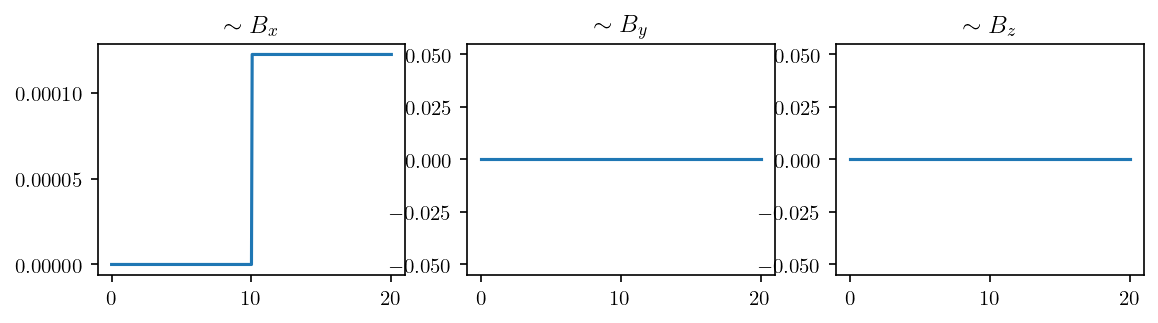

In [4]:
ctrj_raw = pd.read_csv(os.path.join(DATA_PATH,'10','trj/trj10.csv'), index_col=[0,1])

fig, axes = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax = axes[0]
ax.plot(np.array(ctrj_raw.loc[idx[:,1],"t"]),np.array(ctrj_raw.loc[idx[:,1],"mux"]))
ax.set_title("$\\sim B_x$")

ax = axes[1]
ax.plot(np.array(ctrj_raw.loc[idx[:,1],"t"]),np.array(ctrj_raw.loc[idx[:,1],"muy"]))
ax.set_title("$\\sim B_y$")

ax = axes[2]
ax.plot(np.array(ctrj_raw.loc[idx[:,1],"t"]),np.array(ctrj_raw.loc[idx[:,1],"muz"]))
ax.set_title("$\\sim B_z$")

plt.show()

## Vertex counting

In [5]:
raw_data = pd.read_csv(os.path.join(DATA_PATH,'10','average_counts.csv'))
types = ['I','II','III','IV','V','VI']
types

['I', 'II', 'III', 'IV', 'V', 'VI']

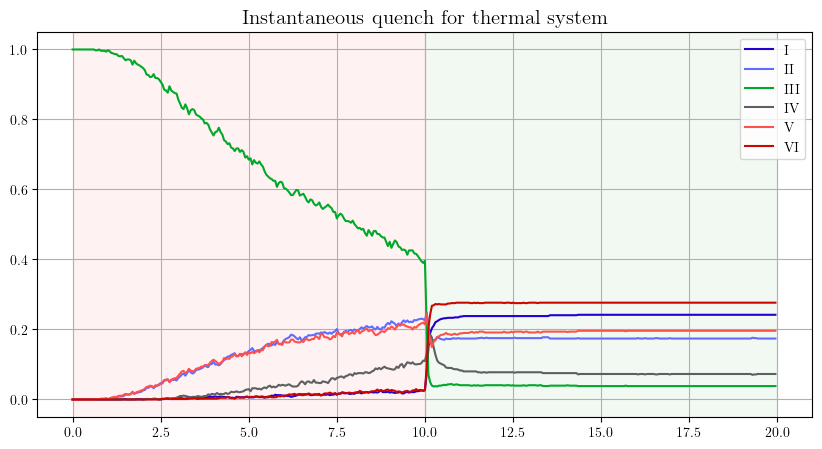

In [8]:
colors = ['#2200cf','#606cff', '#00a92a', '#5d6061', '#ff514c','#ca0600'  ]
fig, ax = plt.subplots(figsize=(10,5))

for vtype, c in zip(types,colors):
    ax.plot(raw_data.time.to_list(),raw_data[vtype],color=c,label=vtype)

ax.set_title('Instantaneous quench for thermal system',fontsize=15)
ax.axvspan(0,10,alpha=0.05, color='red')
ax.axvspan(10,20,alpha=0.05, color='green')

ax.grid()
ax.legend()
plt.show()

In [12]:
N = 10
kappas = pd.read_csv(os.path.join(DATA_PATH,'10','kappa.csv'),index_col=['realization','t'])
kappa_av = []
for r,ctime in kappas.groupby('t'):
    kappa_av.append(np.mean(ctime.kappa))

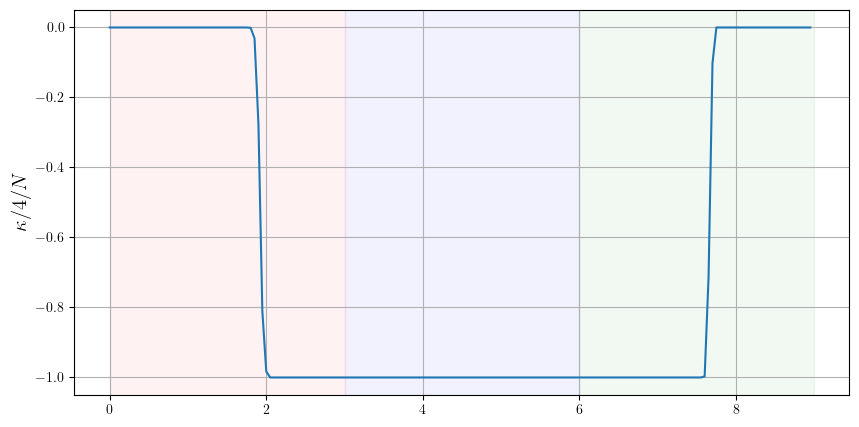

In [18]:
time = kappas.index.get_level_values('t').unique().to_list()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time,np.array(kappa_av)/4/N**2)
ax.set_ylabel('$\\kappa/4/N$',fontsize=15)
ax.axvspan(0,3,alpha=0.05, color='red')
ax.axvspan(3,6,alpha=0.05, color='blue')
ax.axvspan(6,9,alpha=0.05, color='green')

ax.grid()
plt.show()

## Just plotting some shit before doing correlations

In [24]:
trj = pd.read_csv(os.path.join(DATA_PATH,'10','trj/xtrj10.csv'), index_col=[0,1])
trj

x      y    z            dx    dy   dz     t        cx  \
frame id                                                                
0     0     15.0    0.0  0.0 -1.000000e+01  -0.0 -0.0  0.00 -5.000000   
      1     45.0    0.0  0.0  1.000000e+01   0.0  0.0  0.00  5.000000   
      2     75.0    0.0  0.0 -1.000000e+01  -0.0 -0.0  0.00 -5.000000   
      3    105.0    0.0  0.0  1.000000e+01   0.0  0.0  0.00  5.000000   
      4    135.0    0.0  0.0 -1.000000e+01  -0.0 -0.0  0.00 -5.000000   
...          ...    ...  ...           ...   ...  ...   ...       ...   
179   195  150.0  285.0  0.0 -6.123230e-16 -10.0 -0.0  8.95 -0.003998   
      196  180.0  285.0  0.0  6.123230e-16  10.0  0.0  8.95  0.007004   
      197  210.0  285.0  0.0 -6.123230e-16 -10.0 -0.0  8.95  0.007004   
      198  240.0  285.0  0.0  6.123230e-16  10.0  0.0  8.95 -0.003998   
      199  270.0  285.0  0.0 -6.123230e-16 -10.0 -0.0  8.95  0.001007   

                 cy   cz  
frame id                  
0     0    0.000000  0.0  
      1    0.000000  0.0  
      2    0.000000  0.0  
      3    0.000000  0.0  
      4    0.000000  0.0  
...             ...  ...  
179   195 -2.993012  0.0  
      196  3.031006  0.0  
      197 -2.871002  0.0  
      198  3.325989  0.0  
      199 -3.046997  0.0  

[36000 rows x 10 columns]

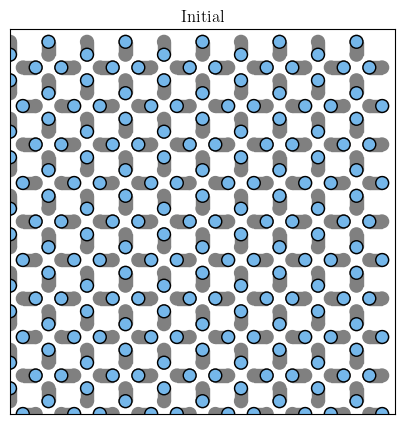

In [29]:
fig, ax = plt.subplots(figsize=(5,5))

ice.draw_frame(trj, frame_no=0,
               region=[0,300,0,300],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

ax.set_title('Initial')
plt.show()

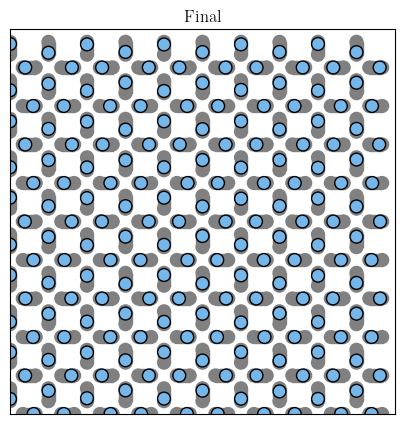

In [30]:
fig, ax = plt.subplots(figsize=(5,5))

ice.draw_frame(trj, frame_no=179,
               region=[0,300,0,300],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

ax.set_title('Final')
plt.show()

## Correlations

In [91]:
rparallels = pd.read_csv(os.path.join(DATA_PATH,'10','rparallel.csv'),index_col=['realization','t','id'])

timeav = []
for pid, cdf_id in rparallels.groupby('id'):
    rav = []
    # i selected one particle
    # and go by the timeseries of that particle separated by realization
    for r, cdf_idr in cdf_id.groupby('realization'):
        corr = aux.autocorrelation(cdf_idr.rp.to_list())
        # append the realization corr ts
        rav.append(corr)
    
    # average the particle corr shenanigans
    rav = np.mean(np.array(rav),axis=0)
    timeav.append(rav)
    

In [92]:
# this has n rows according to particle number
# and t columsn according to the timeseries
np.array(timeav).shape

(200, 180)

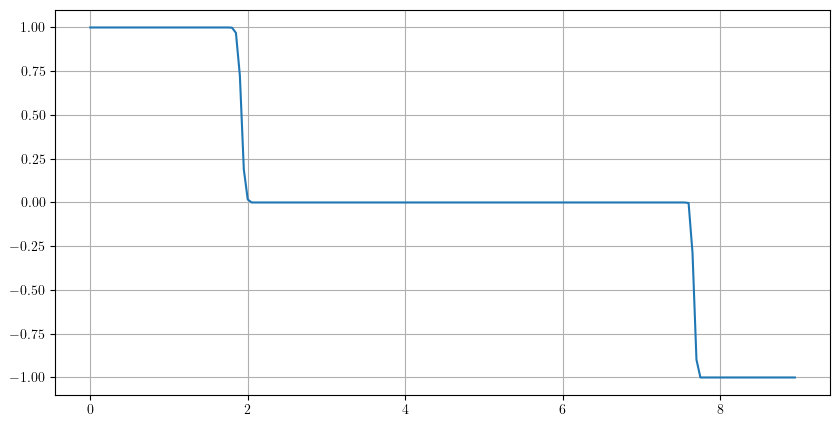

In [97]:
corrav = np.mean(np.array(timeav),axis=0)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time,corrav)
ax.grid()
plt.show()


In [61]:
cumm_rp = []
for pid, cdf in trj.groupby('id'):
    rel = cdf[['cx','cy','cz']].to_numpy()
    spin = cdf[['dx','dy','dz']].to_numpy()
    spin = spin/np.linalg.norm(spin, axis=1)[:,np.newaxis]
    
    rparallel = np.sum(rel*np.abs(spin), axis=1)
    time = cdf.t.to_numpy()
    
    df = pd.DataFrame(rparallel, columns = ['rp'])
    df['t'] = time
    df['id'] = [pid]*len(df)
    print(df)
    break

           rp     t  id
0   -5.000000  0.00   0
1   -4.815100  0.05   0
2   -4.497000  0.10   0
3   -4.477600  0.15   0
4   -4.336400  0.20   0
..        ...   ...  ..
175  3.353201  8.75   0
176  3.284901  8.80   0
177  3.214100  8.85   0
178  3.282600  8.90   0
179  3.424400  8.95   0

[180 rows x 3 columns]
